
### Используемые библиотеки и инструменты:
- **CatBoost** для моделирования.
- **Transformers** для работы с предобученными языковыми моделями и эмбеддингами изображений.
- **Pandas** для обработки данных.
- **Scikit-learn** для расчета метрик, таких как косинусное сходство и логарифмическая потеря.
- **Matplotlib/Seaborn** для визуализации данных и результатов.
- **Tqdm** для отображения прогресса.
- **PIL** для работы с изображениями.

### Описание данных:
Датасет включает следующие данные:
- `view`: Количество просмотров поста.
- `like`: Количество лайков.
- `comment`: Количество комментариев.
- `share_to_message`: Количество пересылок поста в личные сообщения.



## Предобработка данных

### Очистка текстовых данных:
- Тексты постов очищались от лишних символов, таких как HTML-теги (`<br>`), ссылки, эмодзи, а также была произведена нормализация регистра.
- Признаки текста: добавлены такие параметры, как количество восклицательных знаков, количество эмодзи и длина текста.

### Обработка изображений:
- Изображения декодировались из формата base64 и классифицировались с помощью модели CLIP для назначения категорий (например, "мем", "новость").



## Моделирование

### Регрессия с CatBoost:
Использовались модели CatBoost для предсказания вероятности лайков, комментариев и пересылок, основываясь на данных о просмотрах постов.

- **Многотаргетная регрессия:** Для каждого типа взаимодействий (лайки/просмотры, комментарии/просмотры, пересылки/просмотры) модели обучались по отдельности для достижения лучших результатов.
- **Выбор признаков:** Признаки создавались на основе как текстовых, так и визуальных данных.
- **Кросс-валидация:** Применялась K-Fold кросс-валидация для предотвращения переобучения и улучшения обобщающей способности модели.

#### Важность признаков:
Одним из преимуществ CatBoost является возможность оценивать важность признаков, что позволяет понять, какие из признаков оказывают наибольшее влияние на предсказания модели.



## Результаты и оценка

### Оценка модели:
- Использовались метрики **Log Loss** и **Среднеквадратичная ошибка (MSE)** для оценки качества модели. Чем ниже значения этих метрик, тем лучше работает модель.
- **Косинусное сходство**: Текстовые эмбеддинги сравнивались с помощью косинусного сходства для оценки близости текстов.

### Важность признаков:
График важности признаков показал, какие текстовые и визуальные признаки наиболее сильно влияют на предсказания.

### Интерпретация модели:
Модели успешно предсказывали взаимодействия пользователей на основе как текстовых, так и визуальных данных постов. Например, наличие эмодзи, длина текста и определенные категории изображений были сильными индикаторами вовлеченности.



## Заключение и рекомендации

### Заключение:
Наши модели показали хорошие результаты в предсказании взаимодействий пользователей (лайки, комментарии, пересылки) на основе как текстового содержания, так и изображений. Применяя машинное обучение (CatBoost, текстовые эмбеддинги и классификация изображений), мы смогли выявить ключевые факторы, влияющие на вовлеченность пользователей.

### Рекомендации:
- **Для создателей контента VK**: Посты с таргетированными изображениями (например, мемами или новостями) и лаконичным, вовлекающим текстом имеют больше шансов на получение взаимодействий.
- **Дополнительные улучшения**: Применение более продвинутых моделей для обработки текста и изображений может улучшить результаты.


# Jupyter notebook sample

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from deeppavlov.utils.server.metrics import metrics
import numpy as np
from seaborn.algorithms import bootstrap
from sklearn.preprocessing import LabelEncoder

In [2]:
data = pd.read_csv('data/post2ctr_dataset.csv')
data

,view,like,comment,hide,expand,open_photo,open,share_to_message,text,photo
0,10869,185,0,2,0,1947,14,20,NaN,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,9083,227,1,7,4,958,23,2,• &#128571;,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2,5352,25,5,12,598,430,114,4,"Новость, конечно, старенькая, но все равно инт...",/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3,4260,539,5,3,1,138,62,24,Фантазийные бриллианты.,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4,5676,112,2,4,371,271,499,4,Сегодня на стадионе «Динамо» прошли соревнован...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
...,...,...,...,...,...,...,...,...,...,...
23522,14146,355,123,6,7,146,957,1,"Тамара, выиграет в 24 сезоне ?",/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
23523,13392,11,0,3,555,52,106,9,Продажи Manor Lords превысили 1 млн копий. <br...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
23524,21408,1611,9,3,0,453,582,122,NaN,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
23525,65138,269,14,69,2036,172,2390,116,Магическая фраза: Уже оплачено&#33;<br><br>Поз...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


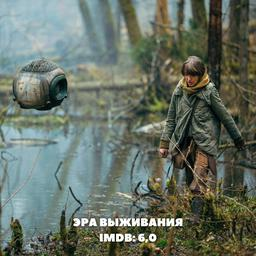

In [3]:
from base64 import b64decode
from io import BytesIO
from PIL import Image

img = Image.open(BytesIO(b64decode(data.loc[10733, "photo"])))
img

In [4]:
# Удаляем столбцы "text" и "photo" и берем логарифм от всех оставшихся числовых столбцов
numeric_columns = data.drop(["text", "photo"], axis=1).columns

# Для предотвращения ошибки с логарифмом от нуля или отрицательных значений добавляем небольшое значение (например, 1)
data[numeric_columns] = np.log(data[numeric_columns] + 1)

data['like_prob'] = data['like'] / data['view']
data['comment_prob'] = data['comment'] / data['view']
data['repost_prob'] = data['share_to_message'] / data['view']
data['text'] = data['text'].fillna('')

data

,view,like,comment,hide,expand,open_photo,open,share_to_message,text,photo,like_prob,comment_prob,repost_prob
0,9.293762,5.225747,0.000000,1.098612,0.000000,7.574558,2.708050,3.044522,,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,0.562285,0.000000,0.327588
1,9.114270,5.429346,0.693147,2.079442,1.609438,6.865891,3.178054,1.098612,• &#128571;,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,0.595697,0.076051,0.120538
2,8.585412,3.258097,1.791759,2.564949,6.395262,6.066108,4.744932,1.609438,"Новость, конечно, старенькая, но все равно инт...",/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,0.379492,0.208698,0.187462
3,8.357259,6.291569,1.791759,1.386294,0.693147,4.934474,4.143135,3.218876,Фантазийные бриллианты.,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,0.752827,0.214396,0.385159
4,8.644178,4.727388,1.098612,1.609438,5.918894,5.605802,6.214608,1.609438,Сегодня на стадионе «Динамо» прошли соревнован...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,0.546887,0.127093,0.186187
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23522,9.557258,5.874931,4.820282,1.945910,2.079442,4.990433,6.864848,0.693147,"Тамара, выиграет в 24 сезоне ?",/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,0.614709,0.504358,0.072526
23523,9.502487,2.484907,0.000000,1.386294,6.320768,3.970292,4.672829,2.302585,Продажи Manor Lords превысили 1 млн копий. <br...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,0.261501,0.000000,0.242314
23524,9.971567,7.385231,2.302585,1.386294,0.000000,6.118097,6.368187,4.812184,,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,0.740629,0.230915,0.482591
23525,11.084279,5.598422,2.708050,4.248495,7.619233,5.153292,7.779467,4.762174,Магическая фраза: Уже оплачено&#33;<br><br>Поз...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,0.505078,0.244315,0.429633


In [5]:
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

In [6]:
columns = data.drop(["text", "photo"], axis=1).columns

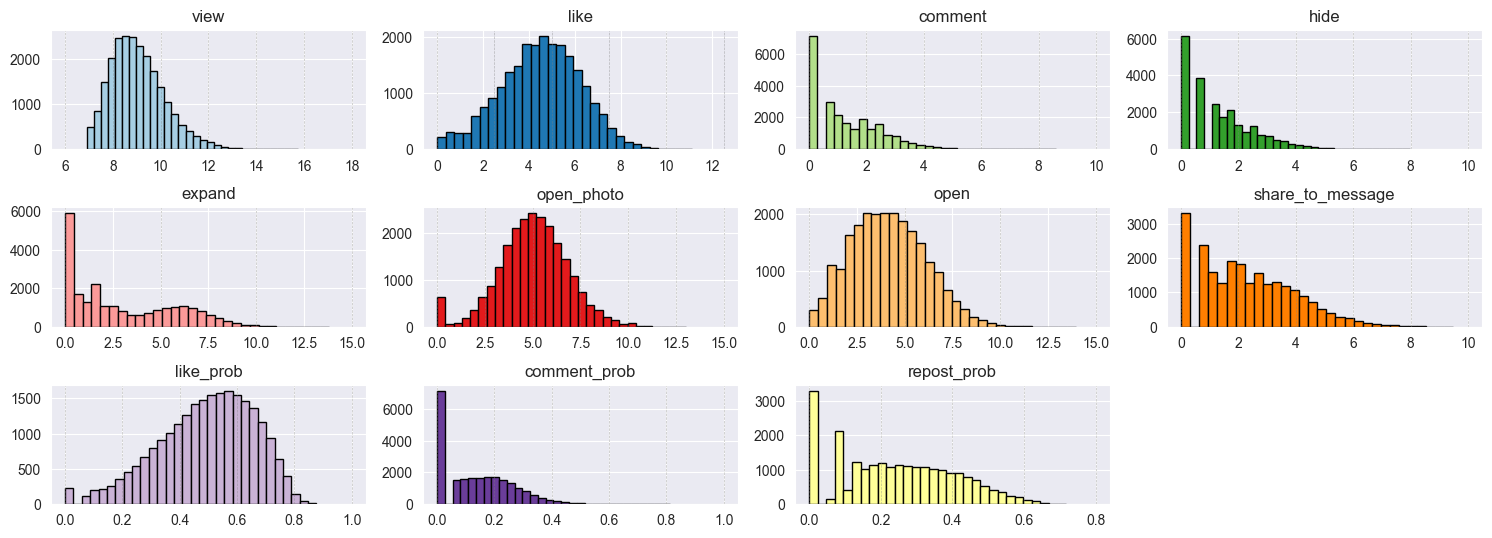

In [7]:
fig, axes = plt.subplots(4, 4, figsize=(15, 7))
axes = axes.flatten()

colors = sns.color_palette("Paired", 11)

for i, col in enumerate(columns):
    ax = axes[i]
    ax.hist(data[col].dropna(), bins=30, color=colors[i % len(colors)], edgecolor='black')
    ax.set_title(col)

    # Disable scientific notation on y-axis.
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.ticklabel_format(style='plain', axis='y')

    for tick in ax.get_xticks():
        if tick < 0: continue
        ax.axvline(x=tick, color='grey', alpha=0.5, linestyle='--', linewidth=0.5)

for j in range(i + 1, len(axes)): axes[j].set_visible(False)

plt.tight_layout(pad=1.0)
plt.show()

<Axes: >

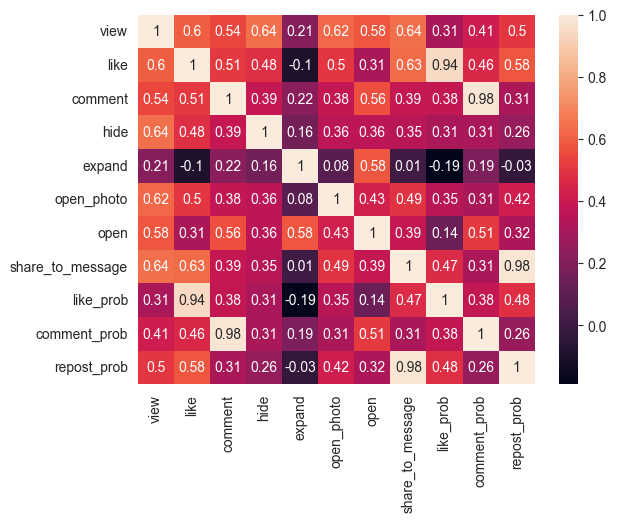

In [8]:
cor_mat = data.drop(["text", "photo"], axis=1).corr()
sns.heatmap(round(cor_mat, 2), annot=True)

Как идея добавить простые, но полезные фичи на основе данного текста до его обработки
Фича 1: показывает как много слов с капсом в тексте, она может быть довольно полезна с учётом того, что это делают для того, что бы затригерить прочитать пост
Фича 2: показывает кол-во слов в посте
Фича 3: показывает кол-во

In [9]:
import re


def count_caps_words(text):
    if isinstance(text, str):
        caps_words = re.findall(r'\b[A-ZА-ЯЁ]{2,}\b', text)
        return len(caps_words)
    else:
        return 0


# Применяем функцию к колонке 'text'
data['caps_words_count'] = data['text'].apply(count_caps_words)

In [10]:
data['word_count'] = data['text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

In [11]:
import emoji
import html


def decode_html_entities(text):
    if isinstance(text, str):
        return html.unescape(text)
    return text


def count_emojis(text):
    if isinstance(text, str):
        return len(emoji.emoji_list(text))
    return 0


data['decoded_text'] = data['text'].apply(decode_html_entities)
data['emoji_count'] = data['decoded_text'].apply(count_emojis)
data.drop("decoded_text", axis=1, inplace=True)

In [12]:
def count_urls(text):
    if isinstance(text, str):
        return len(re.findall(r'http[s]?://\S+', text))
    return 0


data['url_count'] = data['text'].apply(count_urls)

In [13]:
def count_hashtags(text):
    if isinstance(text, str):
        return len(re.findall(r'#\w+', text))
    return 0


data['hashtag_count'] = data['text'].apply(count_hashtags)

In [14]:
def count_mentions(text):
    if isinstance(text, str):
        return len(re.findall(r'@\w+', text))
    return 0


data['mention_count'] = data['text'].apply(count_mentions)

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
nltk.download('stopwords')

stop_words_ru = set(stopwords.words('russian'))
stop_words_en = set(stopwords.words('english'))
combined_stop_words = stop_words_ru.union(stop_words_en)


def count_stopwords(text):
    if isinstance(text, str):
        words = word_tokenize(text.lower(), language='russian')
        return sum(1 for word in words if word in combined_stop_words)
    return 0


# Применение функции к колонке 'text'
data['stopwords_count'] = data['text'].apply(count_stopwords)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hedge\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hedge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
def count_unique_words(text):
    if isinstance(text, str):
        words = word_tokenize(text.lower())
        return len(set(words))
    return 0


data['unique_words_count'] = data['text'].apply(count_unique_words)

In [17]:
def count_questions(text):
    if isinstance(text, str):
        return len(re.findall(r'\?', text))
    return 0


data['question_count'] = data['text'].apply(count_questions)

In [18]:
def caps_ratio(text):
    if isinstance(text, str):
        caps = sum(1 for char in text if char.isupper())
        total = len(text)
        return caps / total if total > 0 else 0
    return 0


data['caps_ratio'] = data['text'].apply(caps_ratio)

In [19]:
def count_numbers(text):
    if isinstance(text, str):
        return len(re.findall(r'\b\d+\b', text))
    return 0


data['number_count'] = data['text'].apply(count_numbers)

In [20]:
# Функция для подсчёта количества <br>
def count_br(text):
    if isinstance(text, str):
        return text.count('<br>')
    return 0


# Применение функции к данным
data['br_count'] = data['text'].apply(count_br)


def first_br_position(text):
    if isinstance(text, str):
        return text.find('<br>')
    return -1


data['first_br_pos'] = data['text'].apply(first_br_position)

In [21]:
data

,view,like,comment,hide,expand,open_photo,open,share_to_message,text,photo,...,url_count,hashtag_count,mention_count,stopwords_count,unique_words_count,question_count,caps_ratio,number_count,br_count,first_br_pos
0,9.293762,5.225747,0.000000,1.098612,0.000000,7.574558,2.708050,3.044522,,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,0,0,0,0,0,0.000000,0,0,-1
1,9.114270,5.429346,0.693147,2.079442,1.609438,6.865891,3.178054,1.098612,• &#128571;,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,1,0,0,5,0,0.000000,1,0,-1
2,8.585412,3.258097,1.791759,2.564949,6.395262,6.066108,4.744932,1.609438,"Новость, конечно, старенькая, но все равно инт...",/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,0,0,19,57,1,0.022801,1,1,221
3,8.357259,6.291569,1.791759,1.386294,0.693147,4.934474,4.143135,3.218876,Фантазийные бриллианты.,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,0,0,0,3,0,0.043478,0,0,-1
4,8.644178,4.727388,1.098612,1.609438,5.918894,5.605802,6.214608,1.609438,Сегодня на стадионе «Динамо» прошли соревнован...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,16,0,8,80,0,0.046572,37,16,112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23522,9.557258,5.874931,4.820282,1.945910,2.079442,4.990433,6.864848,0.693147,"Тамара, выиграет в 24 сезоне ?",/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,0,0,1,7,1,0.033333,1,0,-1
23523,9.502487,2.484907,0.000000,1.386294,6.320768,3.970292,4.672829,2.302585,Продажи Manor Lords превысили 1 млн копий. <br...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,3,0,4,50,0,0.043860,3,4,43
23524,9.971567,7.385231,2.302585,1.386294,0.000000,6.118097,6.368187,4.812184,,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,0,0,0,0,0,0.000000,0,0,-1
23525,11.084279,5.598422,2.708050,4.248495,7.619233,5.153292,7.779467,4.762174,Магическая фраза: Уже оплачено&#33;<br><br>Поз...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,8,0,95,160,7,0.041332,8,25,35


После добавления нужных нам фич, нормализуем текст

In [22]:
def clean_text(text):
    if isinstance(text, str):
        text_decoded = html.unescape(text)
        url_pattern = r'https?://\S+'
        cleaned_text = re.sub(url_pattern, 'url', text_decoded)
        return cleaned_text
    return text

In [23]:
def normalize_text(text):
    if isinstance(text, str):
        # Удаление HTML-тегов
        text = re.sub(r'<br>', ' ', text)

        # Удаление специальных символов (оставляем эмодзи и буквенно-цифровые символы)
        text = ''.join(char for char in text if char.isalnum() or char.isspace() or char in emoji.EMOJI_DATA.values())

        # Удаление лишних пробелов
        text = re.sub(r'\s+', ' ', text).strip()

        # Преобразование текста в нижний регистр для единообразия
        text = text.lower()

        return text
    return ''

In [24]:
def preprocess_text(text):
    text = clean_text(text)
    text = normalize_text(text)
    return text

In [25]:
data['clean_text'] = data['text'].apply(preprocess_text)
data

,view,like,comment,hide,expand,open_photo,open,share_to_message,text,photo,...,hashtag_count,mention_count,stopwords_count,unique_words_count,question_count,caps_ratio,number_count,br_count,first_br_pos,clean_text
0,9.293762,5.225747,0.000000,1.098612,0.000000,7.574558,2.708050,3.044522,,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,0,0,0,0,0.000000,0,0,-1,
1,9.114270,5.429346,0.693147,2.079442,1.609438,6.865891,3.178054,1.098612,• &#128571;,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,1,0,0,5,0,0.000000,1,0,-1,
2,8.585412,3.258097,1.791759,2.564949,6.395262,6.066108,4.744932,1.609438,"Новость, конечно, старенькая, но все равно инт...",/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,0,19,57,1,0.022801,1,1,221,новость конечно старенькая но все равно интере...
3,8.357259,6.291569,1.791759,1.386294,0.693147,4.934474,4.143135,3.218876,Фантазийные бриллианты.,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,0,0,3,0,0.043478,0,0,-1,фантазийные бриллианты
4,8.644178,4.727388,1.098612,1.609438,5.918894,5.605802,6.214608,1.609438,Сегодня на стадионе «Динамо» прошли соревнован...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,16,0,8,80,0,0.046572,37,16,112,сегодня на стадионе динамо прошли соревнования...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23522,9.557258,5.874931,4.820282,1.945910,2.079442,4.990433,6.864848,0.693147,"Тамара, выиграет в 24 сезоне ?",/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,0,1,7,1,0.033333,1,0,-1,тамара выиграет в 24 сезоне
23523,9.502487,2.484907,0.000000,1.386294,6.320768,3.970292,4.672829,2.302585,Продажи Manor Lords превысили 1 млн копий. <br...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,3,0,4,50,0,0.043860,3,4,43,продажи manor lords превысили 1 млн копий сред...
23524,9.971567,7.385231,2.302585,1.386294,0.000000,6.118097,6.368187,4.812184,,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,0,0,0,0,0.000000,0,0,-1,
23525,11.084279,5.598422,2.708050,4.248495,7.619233,5.153292,7.779467,4.762174,Магическая фраза: Уже оплачено&#33;<br><br>Поз...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,8,0,95,160,7,0.041332,8,25,35,магическая фраза уже оплачено позвольте себе б...


In [26]:
# numeric_columns = (data.drop(["text", "photo"], axis=1).iloc[:, 11:]).columns
# data[numeric_columns] = np.log(data[numeric_columns] + 1)
# data

IMAGE TO CATEGORY

In [27]:
from tqdm.auto import tqdm

In [28]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from base64 import b64decode
from io import BytesIO

# Загрузка модели CLIP с Hugging Face
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLIPModel.from_pretrained("zer0int/CLIP-GmP-ViT-L-14").to(device)
processor = CLIPProcessor.from_pretrained("zer0int/CLIP-GmP-ViT-L-14")

# Генерация категорий на основе контекста изображения
categories = [
    "a russian meme", "a news", "a drawing", "nature", "a building",
    "a car", "animals" "a quote", "a motivational post",
    "a lifestyle post", "a personal blog post", "a recipe", "an advertisement",
    "a product review", "a tutorial", "an holiday", "a sport",
    "a fashion post", "a concert", "a political post", "a scientific post",
    "a fitness post", "a travel post", "a historical post",
    "a gaming post", "a movie", "a social cause post", "a technological post", "a food post", "a challenge",
    "a reaction video", "an infographic", "a chart", "a horoscope", "a competition",
    "a giveaway", "a promotional event", "a survey", "a fundraiser", "a job posting",
    "an educational post", "a podcast", "a behind the scenes post", "a weather update", "an animal rescue post",
    "an art post", "a celebrity news", "a fun fact", "a user poll", "a travel guide",
    "a fitness challenge", "a shopping list", "a job advertisement",
    "a scientific discovery", "a music post", "a public service announcement", "a cooking tip",
    "a beauty tutorial", "a diet tip", "a business news", "a family post", "a parenting tip",
    "a school project", "a charity event", "a photography tip", "a community update",
    "a product launch", "a lifestyle hack", "a workout routine", "a relationship advice post",
    "a technology review", "a finance tip", "a stock market update",
    "a live stream", "a book review", "a concert recap", "a celebrity interview", "a home decor post",
    "a virtual tour", "a fan fiction", "a mindfulness tip", "a fitness transformation",
    "a makeup tutorial", "a travel itinerary", "a gym", "a gardening tip", "lego", "toy"
]


# Функция для предсказания категории изображения
def classify_image_base64(base64_str):
    # Декодирование base64 изображения
    image = Image.open(BytesIO(b64decode(base64_str)))

    # Токенизация категорий и изображения
    inputs = processor(text=categories, images=image, return_tensors="pt", padding=True).to(device)

    # Прогон через модель
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # Сходство изображений с текстом
    probs = logits_per_image.softmax(dim=1)  # Вероятности

    # Выбор лучшего описания
    best_category_index = probs.argmax().item()
    best_category = categories[best_category_index]

    return best_category

tqdm.pandas()

data['photo_category'] = data['photo'].progress_apply(classify_image_base64)
data

C:\Users\hedge\DataspellProjects\vklab_recsys\venv\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/23527 [00:00<?, ?it/s]

C:\Users\hedge\DataspellProjects\vklab_recsys\venv\lib\site-packages\transformers\models\clip\modeling_clip.py:491: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


KeyboardInterrupt: 

In [29]:
from sklearn.preprocessing import LabelEncoder

In [30]:
le = LabelEncoder()
data['photo_category'] = le.fit_transform(data['photo_category'])
data

,view,like,comment,hide,expand,open_photo,open,share_to_message,text,photo,...,mention_count,stopwords_count,unique_words_count,question_count,caps_ratio,number_count,br_count,first_br_pos,clean_text,photo_category
0,9.293762,5.225747,0.000000,1.098612,0.000000,7.574558,2.708050,3.044522,,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,0,0,0,0.000000,0,0,-1,,20
1,9.114270,5.429346,0.693147,2.079442,1.609438,6.865891,3.178054,1.098612,• &#128571;,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,0,5,0,0.000000,1,0,-1,,18
2,8.585412,3.258097,1.791759,2.564949,6.395262,6.066108,4.744932,1.609438,"Новость, конечно, старенькая, но все равно инт...",/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,19,57,1,0.022801,1,1,221,новость конечно старенькая но все равно интере...,49
3,8.357259,6.291569,1.791759,1.386294,0.693147,4.934474,4.143135,3.218876,Фантазийные бриллианты.,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,0,3,0,0.043478,0,0,-1,фантазийные бриллианты,30
4,8.644178,4.727388,1.098612,1.609438,5.918894,5.605802,6.214608,1.609438,Сегодня на стадионе «Динамо» прошли соревнован...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,8,80,0,0.046572,37,16,112,сегодня на стадионе динамо прошли соревнования...,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23522,9.557258,5.874931,4.820282,1.945910,2.079442,4.990433,6.864848,0.693147,"Тамара, выиграет в 24 сезоне ?",/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,1,7,1,0.033333,1,0,-1,тамара выиграет в 24 сезоне,44
23523,9.502487,2.484907,0.000000,1.386294,6.320768,3.970292,4.672829,2.302585,Продажи Manor Lords превысили 1 млн копий. <br...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,4,50,0,0.043860,3,4,43,продажи manor lords превысили 1 млн копий сред...,28
23524,9.971567,7.385231,2.302585,1.386294,0.000000,6.118097,6.368187,4.812184,,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,0,0,0,0.000000,0,0,-1,,58
23525,11.084279,5.598422,2.708050,4.248495,7.619233,5.153292,7.779467,4.762174,Магическая фраза: Уже оплачено&#33;<br><br>Поз...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,95,160,7,0.041332,8,25,35,магическая фраза уже оплачено позвольте себе б...,79


EMBEDINGS

In [31]:
from transformers import AutoTokenizer, AutoModel
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Загрузка модели и токенизатора
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

C:\Users\hedge\DataspellProjects\vklab_recsys\venv\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [32]:
from sklearn.metrics.pairwise import cosine_similarity
def extract_features(text):
    # Токенизация текста
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)

    # Прогон текста через модель
    with torch.no_grad():
        outputs = model(**inputs)

    # Получение эмбеддингов из последнего слоя
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Среднее по токенам
    return embeddings.cpu().detach().numpy()

# Пример: извлечение фич из описания поста
tqdm.pandas()

data['text_feature'] = data['clean_text'].progress_apply(extract_features)

  0%|          | 0/23527 [00:00<?, ?it/s]

In [33]:
# Преобразование всех эмбеддингов в массив
embeddings_matrix = np.vstack(data['text_feature'].values)

# Теперь можно использовать cosine_similarity на массиве эмбеддингов
similarities = cosine_similarity(embeddings_matrix)

In [34]:
similarity_df = pd.DataFrame(similarities, columns=[f"similarity_to_{i}" for i in range(similarities.shape[1])])
data = pd.concat([data, similarity_df], axis=1)
data.head(1)

,view,like,comment,hide,expand,open_photo,open,share_to_message,text,photo,...,similarity_to_23517,similarity_to_23518,similarity_to_23519,similarity_to_23520,similarity_to_23521,similarity_to_23522,similarity_to_23523,similarity_to_23524,similarity_to_23525,similarity_to_23526
0,9.293762,5.225747,0.0,1.098612,0.0,7.574558,2.70805,3.044522,,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,1.0,0.921817,1.0,0.934945,0.942313,0.945852,0.916099,1.0,0.904372,0.936116


DATA PREPARE

In [35]:
X = data.drop(
    ['repost_prob', 'comment_prob', 'like_prob', 'like', 'share_to_message', 'comment', 'text', 'photo', "clean_text", "text_feature"], axis=1)
#X = data[["hide","expand"]]
y = data[['like_prob', 'comment_prob', 'share_to_message']]

In [36]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# X = pd.DataFrame(X)
# X

In [37]:
X = X.to_numpy()
y = y.to_numpy()

MODEL TRAINING

In [38]:
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [39]:
base_model = CatBoostRegressor(
    iterations=1000,
    depth=5,  
    loss_function='MultiRMSE', 
    eval_metric='MultiRMSE', 
    learning_rate=0.2, 
    l2_leaf_reg=9.0, 
    early_stopping_rounds=5,  
    use_best_model=True,  
    random_state=42, 
    verbose=100,
    devices='0', 
    max_bin=254,  
)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

kf = KFold(n_splits=5, random_state=42, shuffle=True)

global_mae_score = []
global_mse_score = []
global_r2_score = []

test_pred = []
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    base_model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), early_stopping_rounds=5)

    pred = base_model.predict(X_val_fold)

    score_mae = mean_absolute_error(y_val_fold, pred, multioutput='uniform_average')
    score_mse = mean_squared_error(y_val_fold, pred, multioutput='uniform_average')
    score_r2 = r2_score(y_val_fold, pred, multioutput='uniform_average')

    global_mae_score.append(score_mae)
    global_mse_score.append(score_mse)
    global_r2_score.append(score_r2)

    test_pred.append(base_model.predict(X_test))

print(f'MSE: {np.mean(global_mae_score, axis=0)}')
print(f'MAE: {np.mean(global_mse_score, axis=0)}')
print(f'R²: {np.mean(global_r2_score, axis=0)}')

score_mae = mean_absolute_error(y_test, np.mean(test_pred, axis=0), multioutput='uniform_average')
score_mse = mean_squared_error(y_test, np.mean(test_pred, axis=0), multioutput='uniform_average')
score_r2 = r2_score(y_test, np.mean(test_pred, axis=0), multioutput='uniform_average')

print(f'MSE: {score_mae}')
print(f'MAE: {score_mse}')
print(f'R²: {score_r2}')

# MSE: 0.35086770422663693
# MAE: 0.41715552458667354
# R²: 0.46355646915284376
# MSE: 0.34321496389247347
# MAE: 0.3986518229052562
# R²: 0.4745522289147374

0:	learn: 1.5762182	test: 1.5700421	best: 1.5700421 (0)	total: 2.93s	remaining: 48m 44s
100:	learn: 1.1021886	test: 1.1336091	best: 1.1336091 (100)	total: 1m 57s	remaining: 17m 22s
200:	learn: 1.0342798	test: 1.1169314	best: 1.1166737 (198)	total: 3m 49s	remaining: 15m 11s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 1.111872214
bestIteration = 240

Shrink model to first 241 iterations.
0:	learn: 1.5754380	test: 1.5702048	best: 1.5702048 (0)	total: 1.42s	remaining: 23m 37s
100:	learn: 1.0887049	test: 1.1894266	best: 1.1894266 (100)	total: 1m 53s	remaining: 16m 49s
200:	learn: 1.0185319	test: 1.1705052	best: 1.1705052 (200)	total: 3m 44s	remaining: 14m 51s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 1.167139378
bestIteration = 232

Shrink model to first 233 iterations.
0:	learn: 1.5724231	test: 1.5852872	best: 1.5852872 (0)	total: 1.41s	remaining: 23m 24s
100:	learn: 1.0991881	test: 1.1449189	best: 1.1449189 (100)	total: 1m 53s	remaining: 16m 50s

In [41]:
feature_importances = base_model.get_feature_importance()
for feature_name, importance in zip(pd.DataFrame(X_train).columns, feature_importances):
    print(f"{feature_name}: {importance:.4f}")

0: 39.1861
1: 1.9885
2: 0.8415
3: 12.1668
4: 5.0429
5: 0.0000
6: 0.0000
7: 0.2412
8: 0.0000
9: 0.0000
10: 0.1507
11: 0.0000
12: 0.0293
13: 0.4626
14: 0.3460
15: 0.3354
16: 0.2349
17: 0.3172
18: 5.5544
19: 0.0000
20: 0.0000
21: 0.0000
22: 0.0104
23: 0.0000
24: 0.0000
25: 0.0000
26: 0.0000
27: 0.0000
28: 0.0000
29: 0.0000
30: 0.0000
31: 0.0000
32: 0.0000
33: 0.0000
34: 0.0000
35: 0.0000
36: 0.0000
37: 0.0000
38: 0.0000
39: 0.0000
40: 0.0000
41: 0.0000
42: 0.0000
43: 0.0000
44: 0.0064
45: 0.0000
46: 0.0000
47: 0.0000
48: 0.0000
49: 0.0000
50: 0.0000
51: 0.0000
52: 0.0000
53: 0.0000
54: 0.0000
55: 0.0000
56: 0.0000
57: 0.0000
58: 0.0000
59: 0.0000
60: 0.0000
61: 0.0000
62: 0.0000
63: 0.0000
64: 0.0000
65: 0.0000
66: 0.0000
67: 0.0000
68: 0.0000
69: 0.0000
70: 0.0000
71: 0.0000
72: 0.0000
73: 0.0000
74: 0.0000
75: 0.0000
76: 0.0000
77: 0.0000
78: 0.0000
79: 0.0000
80: 0.0000
81: 0.0000
82: 0.0000
83: 0.0000
84: 0.0000
85: 0.0000
86: 0.0000
87: 0.0000
88: 0.0000
89: 0.0000
90: 0.0000
91: 0.0